# Machine Learning Assignment 2
For our second assignment for the course Machine Learning, we are predicting the status of pumps, from the competition https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/

Current rank: top 12% in the competition

Final Score: 0.8133


Load libraries

In [1]:
import pandas as pd
import numpy as np
from fancyimpute import KNN
from textblob import TextBlob
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn import preprocessing
import vapeplot
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module

Import train dataset, Y-label to predict and test dataset

In [2]:
train = pd.read_csv('~/Documents/Modules/Term 2/Machine Learning II/Assignment 2/train.csv')
Y = pd.read_csv('~/Documents/Modules/Term 2/Machine Learning II/Assignment 2/ylabel.csv')
test = pd.read_csv('~/Documents/Modules/Term 2/Machine Learning II/Assignment 2/test.csv')

First overlook of data

In [3]:
train.shape

(59400, 40)

In [4]:
test.shape

(14850, 40)

Remove the ID column as it has no predictive power

In [5]:
del train['id']
del Y['id']
test_id = test['id'] # save test id for later
del test['id']

In [6]:
train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


Joining data for cleaning

In [7]:
frames = [train, test]

df = pd.concat(frames)

In [8]:
# resetting indices 
df.index = np.arange(df.shape[0])

In [9]:
df.shape

(74250, 39)

# Feature Engineering

Checking the amount of unique values in each column.. there seem to be alot!

In [10]:
uniques = []
for i in df.columns:
    x = len(df[i].unique())
    uniques.append(x)

In [11]:
print(uniques)

[102, 369, 2141, 2456, 2411, 71870, 71869, 45684, 68, 9, 21426, 21, 27, 20, 125, 2098, 1128, 3, 1, 13, 2869, 3, 55, 18, 13, 7, 12, 5, 7, 7, 8, 6, 5, 5, 10, 7, 3, 7, 6]


Let's reduce a bit

In [12]:
# gps_height, most are 0, so I will delete this column 
del df['gps_height']

In [13]:
# delete latitude and longitude.. we already have location information
del df['longitude']
del df['latitude']

In [14]:
# 10 most popular for wpt_name
df['wpt_name'].value_counts()

def wpt_name_wrangler(row):  
    if row['wpt_name']=='none':
        return 'none'
    elif row['wpt_name']=='Shuleni':
        return 'Shuleni'
    elif row['wpt_name']=='Zahanati':
        return 'Zahanati'
    elif row['wpt_name']=='Msikitini':
        return 'Msikitini'
    elif row['wpt_name']=='Kanisani':
        return 'Kanisani'    
    elif row['wpt_name']=='Sokoni':
        return 'Sokoni'
    elif row['wpt_name']=='Bombani':
        return 'Bombani'
    elif row['wpt_name']=='Ofisini':
        return 'Ofisini'
    elif row['wpt_name']=='School':
        return 'School'  
    elif row['wpt_name']=='Shule Ya Msingi':
        return 'Shule Ya Msingi'  
    else:
        return 'other'
    
df['wpt_name'] = df.apply(lambda row: wpt_name_wrangler(row), axis=1)

Let's now investigate some features that appear to have similar values

In [15]:
df.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'installer', 'wpt_name',
       'num_private', 'basin', 'subvillage', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'recorded_by', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [16]:
#extraction_type_group and extraction_type_class

print(df['extraction_type_group'].value_counts())
print(df['extraction_type_class'].value_counts())

# I will keep extraction_type_group as it contains more information

del df['extraction_type_class']

gravity            33263
nira/tanira        10205
other               8102
submersible         7772
swn 80              4588
mono                3628
india mark ii       3029
afridev             2208
rope pump            572
other handpump       447
wind-powered         152
other motorpump      149
india mark iii       135
Name: extraction_type_group, dtype: int64
gravity         33263
handpump        20612
other            8102
submersible      7772
motorpump        3777
rope pump         572
wind-powered      152
Name: extraction_type_class, dtype: int64


In [17]:
# management and management group

print(df['management'].value_counts())
print(df['management_group'].value_counts())

# maybe best to keep both here

vwc                 50624
wug                  8108
water board          3688
wua                  3118
private operator     2504
parastatal           2229
water authority      1123
other                1083
company               859
unknown               683
other - school        126
trust                 105
Name: management, dtype: int64
user-group    65538
commercial     4591
parastatal     2229
other          1209
unknown         683
Name: management_group, dtype: int64


In [18]:
# payment and payment type

print(df['payment'].value_counts())
print(df['payment_type'].value_counts())

# these are the same, so I will delete payment

del df['payment']

never pay                31712
pay per bucket           11266
pay monthly              10397
unknown                  10149
pay when scheme fails     4842
pay annually              4570
other                     1314
Name: payment, dtype: int64
never pay     31712
per bucket    11266
monthly       10397
unknown       10149
on failure     4842
annually       4570
other          1314
Name: payment_type, dtype: int64


In [19]:
# water_quality and quality_group

print(df['water_quality'].value_counts())
print(df['quality_group'].value_counts())

# they are the same, so here I will delete quality_group as water_quality is more detailed

del df['quality_group']

soft                  63505
salty                  6082
unknown                2345
milky                  1005
coloured                623
salty abandoned         423
fluoride                244
fluoride abandoned       23
Name: water_quality, dtype: int64
good        63505
salty        6505
unknown      2345
milky        1005
colored       623
fluoride      267
Name: quality_group, dtype: int64


In [20]:
# quantitiy and quantity_group

print(df['quantity'].value_counts())
print(df['quantity_group'].value_counts())

# the same, so I will delete quantity_group

del df['quantity_group']

enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: quantity, dtype: int64
enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: quantity_group, dtype: int64


In [21]:
# source, source_type and source_class

print(df['source'].value_counts())
print(df['source_type'].value_counts())
print(df['source_class'].value_counts())

# here I will delete source_type since source is more detailed and source_class is different

del df['source_type']

spring                  21216
shallow well            21140
machine dbh             13822
river                   11964
rainwater harvesting     2863
hand dtw                 1108
lake                      950
dam                       840
other                     261
unknown                    86
Name: source, dtype: int64
spring                  21216
shallow well            21140
borehole                14930
river/lake              12914
rainwater harvesting     2863
dam                       840
other                     347
Name: source_type, dtype: int64
groundwater    57286
surface        16617
unknown          347
Name: source_class, dtype: int64


In [22]:
# waterpoint_type and waterpoint_type_group

print(df['waterpoint_type'].value_counts())
print(df['waterpoint_type_group'].value_counts())

# The same info, so I will delete waterpoint_type_group

del df['waterpoint_type_group']

communal standpipe             35628
hand pump                      21884
other                           8010
communal standpipe multiple     7611
improved spring                  959
cattle trough                    150
dam                                8
Name: waterpoint_type, dtype: int64
communal standpipe    43239
hand pump             21884
other                  8010
improved spring         959
cattle trough           150
dam                       8
Name: waterpoint_type_group, dtype: int64


Now, the columns look better!

In [23]:
df.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'installer', 'wpt_name',
       'num_private', 'basin', 'subvillage', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'recorded_by', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'management', 'management_group', 'payment_type', 'water_quality',
       'quantity', 'source', 'source_class', 'waterpoint_type'],
      dtype='object')

I will also normalise the population column, as it appears to be skewed

In [24]:
df.population.skew()

11.7806153769686

In [25]:
df.population = df.population.apply(lambda x: np.log10(x+1))

# Creating a few variables

We use the Current_date as the starting point to create two new features: operation_time of the well and the month of the last recorded status

In [26]:
df['current_date']='2014-01-01'

Operation_time, measures the period of the last recorded status and the current date. 

In [27]:
df['operation_time']=df.current_date.apply(pd.to_datetime)-df.date_recorded.apply(pd.to_datetime)

df['operation_time']= df.operation_time.astype('timedelta64[D]').astype(int)

Month of the last recorded status

In [28]:
df['month']=pd.to_datetime(df.date_recorded).dt.month

# Dealing with NA's

In [29]:
print(df.isnull().sum())

amount_tsh                   0
date_recorded                0
funder                    4504
installer                 4532
wpt_name                     0
num_private                  0
basin                        0
subvillage                 470
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            4155
recorded_by                  0
scheme_management         4846
scheme_name              35258
permit                    3793
construction_year            0
extraction_type              0
extraction_type_group        0
management                   0
management_group             0
payment_type                 0
water_quality                0
quantity                     0
source                       0
source_class                 0
waterpoint_type              0
current_date                 0
operation_time               0
month   

From this, we can see that there are NA's in columns 'funder', 'installer', 'subvillage', 'public_meeting', 'scheme_management', 'scheme_name', 'permit'. Let's look at them one by one.

FUNDER (who funded the well) 
- 3635 missing values + multiple misspelled datapoints. I will impute 'Unkown' as I think that this information has value in itself being missing. If it doesnt yield good results I will try other techniques such as KNN.

In [30]:
df['funder'].nunique()

2140

In [31]:
df['funder'] = df['funder'].fillna('unknown')

df['funder'].isnull().sum()

0

Distinct value reduction - assign top 10 values and 'Other' to rest 

In [32]:
def funder_wrangler(row):  
    '''Keep top 5 values and set the rest to 'other'''

    if row['funder']=='Government Of Tanzania':
        return 'gov'
    elif row['funder']=='Danida':
        return 'danida'
    elif row['funder']=='Hesawa':
        return 'hesawa'
    elif row['funder']=='Rwssp':
        return 'rwssp'
    elif row['funder']=='World Bank':
        return 'world_bank'   
    elif row['funder']=='unknown':
        return 'unknown' 
    elif row['funder']=='Kkkt':
        return 'Kkkt'
    elif row['funder']=='World Vision':
        return 'World Vision'
    elif row['funder']=='Unicef':
        return 'Unicef'   
    elif row['funder']=='Tasaf':
        return 'Tasaf' 
    else:
        return 'other'
    
df['funder'] = df.apply(lambda row: funder_wrangler(row), axis=1)

We tried to correct the misspelled word with TextBlob, however it did not yield a satisfactory result, as a lot of "correct" abbrevations etc were corrected, so will leave it out for now

In [28]:
# correcting misspelled with textblob 

# train['funder'] = train.funder.apply(lambda txt: ''.join(TextBlob(txt).correct()))

INSTALLER (who installed the well) 
- 3655 missing values. I will handle this the same way as 'funder'

In [33]:
df['installer'].nunique()

2410

In [34]:
df['installer'] = df['installer'].fillna('unknown')

df['installer'].isnull().sum()

0

Distinct value reduction - assign top 10 values and 'Other' to rest

In [35]:
def installer_wrangler(row):
    if row['installer']=='DWE':
        return 'dwe'
    elif row['installer']=='Government':
        return 'gov'
    elif row['installer']=='RWE':
        return 'rwe'
    elif row['installer']=='Commu':
        return 'commu'
    elif row['installer']=='DANIDA':
        return 'danida'
    elif row['installer']=='unknown':
        return 'unknown' 
    elif row['installer']=='KKKT':
        return 'KKKT'
    elif row['installer']=='Hesawa':
        return 'Hesawa'
    elif row['installer']=='0':
        return '0'
    elif row['installer']=='TCRS':
        return 'TCRS' 
    else:
        return 'other'  

df['installer'] = df.apply(lambda row: installer_wrangler(row), axis=1)

SUBVILLAGE (geographic location) 
- 371 missing values. There are no missing values for other regional information however, so I will group by region and then district mode, and take the mode for subvillage.

In [36]:
df['subvillage'].nunique()

21425

In [37]:
# grouping by region and filling with the mode for each region
df['subvillage'] = df.groupby(['region', 'district_code'])['subvillage'].fillna(df['subvillage'].mode()[0])

df['subvillage'].isnull().sum()

0

Distinct value reduction - assign top 10 values and 'Other' to rest

In [38]:
def subvillage_wrangler(row):
    if row['subvillage']=='Madukani':
        return 'Madukani'
    elif row['subvillage']=='Shuleni':
        return 'Shuleni'
    elif row['subvillage']=='Majengo':
        return 'Majengo'
    elif row['subvillage']=='Kati':
        return 'Kati'
    elif row['subvillage']=='Mtakuja':
        return 'Mtakuja'
    elif row['subvillage']=='Sokoni':
        return 'Sokoni'
    elif row['subvillage']=='M':
        return 'M'
    elif row['subvillage']=='Muungano':
        return 'Muungano'
    elif row['subvillage']=='Mbuyuni':
        return 'Mbuyuni'
    elif row['subvillage']=='Songambele':
        return 'Songambele'
    else:
        return 'other'  

df['subvillage'] = df.apply(lambda row: subvillage_wrangler(row), axis=1)

PUBLIC MEETING (True/False) 
- 3334 missing values. Answer True occurs the most frequent, 91% of the answers are True. Group by funder_category and impute the mode. 

In [39]:
df.public_meeting.describe()

count     70095
unique        2
top        True
freq      63749
Name: public_meeting, dtype: object

In [40]:
df['public_meeting'] = df.groupby('funder')['public_meeting'].fillna(df['public_meeting'].mode()[0])

SCHEME MANAGEMENT (who operates the waterpoint) 
- 3877 missing values. Here I will group by region, district_code and management, and impute the mode

In [41]:
df['scheme_management']
df['scheme_management'].nunique()
df['scheme_management'].describe()

count     69404
unique       12
top         VWC
freq      45917
Name: scheme_management, dtype: object

In [42]:
df['scheme_management'] = df.groupby(['region', 'district_code', 'management'])['scheme_management'].fillna(train['scheme_management'].mode()[0])

df['scheme_management'].isnull().sum()

0

SCHEME NAME (who operates the waterpoint) 
- 28166 missing values. I will group by scheme management and impute the mode.

In [43]:
df['scheme_name'] = df.groupby('scheme_management')['scheme_name'].fillna(df['scheme_name'].mode()[0])

df['scheme_name'].isnull().sum()

0

In [44]:
df['scheme_name'].nunique()

2868

Distinct value reduction - assign top 10 values and 'Other' to rest

In [45]:
def scheme_name_wrangler(row):
    if row['scheme_name']=='K':
        return 'K'
    elif row['scheme_name']=='None':
        return 'None'
    elif row['scheme_name']=='Borehole':
        return 'Borehole'
    elif row['scheme_name']=='Chalinze wate':
        return 'Chalinze wate'
    elif row['scheme_name']=='M':
        return 'M'
    elif row['scheme_name']=='DANIDA':
        return 'DANIDA'
    elif row['scheme_name']=='Government':
        return 'Government'
    elif row['scheme_name']=='Ngana water supplied scheme':
        return 'Ngana water supplied scheme'
    elif row['scheme_name']=="wanging'ombe water supply s":
        return "wanging'ombe water supply s"
    elif row['scheme_name']=='Bagamoyo wate':
        return 'Bagamoyo wate'
    else:
        return 'other'  

df['scheme_name'] = df.apply(lambda row: scheme_name_wrangler(row), axis=1)

PERMIT (is the waterpoint is permitted) 
- 3056 missing values. I will group by funder and impute the mode, as I am assuming that only certain funders will fund a pump without a permit

In [46]:
df['permit'].describe()

count     70457
unique        2
top        True
freq      48606
Name: permit, dtype: object

In [47]:
df['permit'] = df.groupby('funder')['permit'].fillna(df['permit'].mode()[0])

That's it for NA imputation! 

In [48]:
# get dummies for modelling
df_dum = pd.get_dummies(df)

In [49]:
df_dum.shape

(74250, 2789)

Split back to train and test

In [50]:
train_dum = df_dum[:59400]
test_dum = df_dum[59400:]

Splitting train set for cross-validation

In [51]:
X_train, X_test, y_train, y_test = train_test_split(train_dum, Y, test_size=0.1, random_state=10)

# Random Forest
The base model will be a RandomForest with all of the varaibles 

In [54]:
# random forest classifier
m_rf = make_pipeline(MaxAbsScaler(), RandomForestClassifier(n_estimators=1000)).fit(X_train, y_train.values.ravel())

Confusion Matrix

Confusion matrix, without normalization
[[2848  108  312]
 [ 190  155   67]
 [ 449   45 1766]]
Normalized confusion matrix
[[0.87 0.03 0.1 ]
 [0.46 0.38 0.16]
 [0.2  0.02 0.78]]


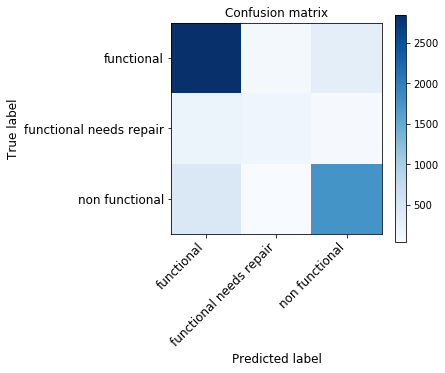

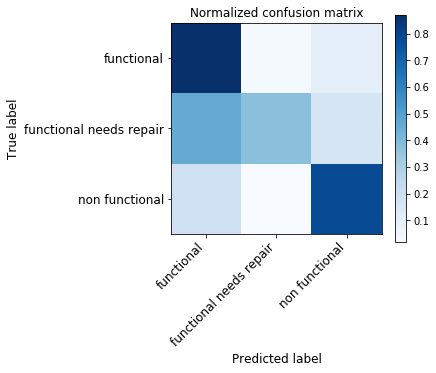

Test Score 0.8028619528619528


In [55]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

from sklearn.metrics import confusion_matrix

labels=['functional','functional needs repair','non functional']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=12)
    plt.yticks(tick_marks, labels , fontsize=12)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)


# Compute confusion matrix
cm = confusion_matrix(y_test, m_rf.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()
print ('Test Score', cm.diagonal().sum()/float(cm.sum()))

Make predictions

In [50]:
# prediction
rf1_preds = m_rf.predict(test_dum)

In [51]:
# convert to CSV for submission 
RandF = pd.DataFrame(rf1_preds)
RandF.to_csv('RF5.csv', index = False)

# LDA 

Next we try a Linear Discriminant Analysis model, which is known to be useful when having a multi-class problem 

In [72]:
lda = LinearDiscriminantAnalysis()

Fit the model

In [ ]:
m_lda = lda.fit(X_train, y_train.values.ravel())

Confusion matrix

In [ ]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

from sklearn.metrics import confusion_matrix

labels=['functional','functional needs repair','non functional']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=12)
    plt.yticks(tick_marks, labels , fontsize=12)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)


# Compute confusion matrix
cm = confusion_matrix(y_test, m_lda.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()
print ('Test Score', cm.diagonal().sum()/float(cm.sum()))

In [ ]:
# make predictions 
lda_preds = m_lda.predict(test_dum)

Convert to CSV

In [ ]:
LDA = pd.DataFrame(lda_preds)
LDA.to_csv("LDA1.csv", index=False)

# Extra Trees Classifier

Extremely Randomized Trees. Skips the bootstrapping idea of Random Forest, and instead of trying to find an optimal cut-point for each one of the K randomly chosen features at each node, it selects a cut-point at random.

This model gave us the best result at 0.8133 in the competition.

In [53]:
m_etc = make_pipeline(MaxAbsScaler(), ExtraTreesClassifier(n_estimators=1000,min_samples_split=10)).fit(X_train, y_train.values.ravel())

Confusion Matrix

Confusion matrix, without normalization
[[2915   78  275]
 [ 212  142   58]
 [ 467   32 1761]]
Normalized confusion matrix
[[0.89 0.02 0.08]
 [0.51 0.34 0.14]
 [0.21 0.01 0.78]]


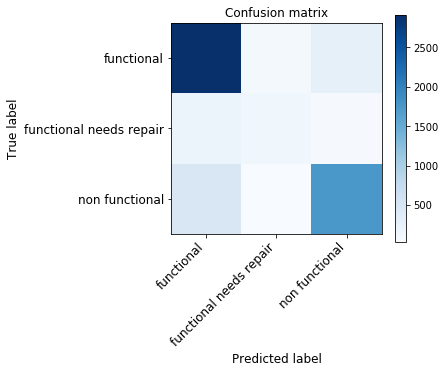

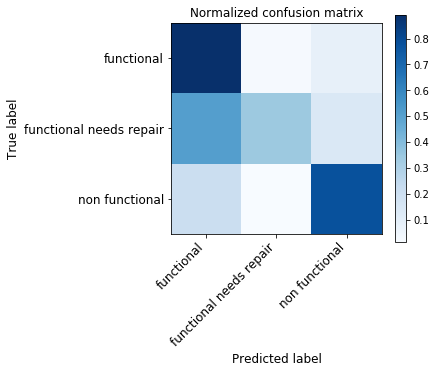

Test Score 0.8111111111111111


In [54]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

from sklearn.metrics import confusion_matrix

labels=['functional','functional needs repair','non functional']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=12)
    plt.yticks(tick_marks, labels , fontsize=12)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)


# Compute confusion matrix
cm = confusion_matrix(y_test, m_etc.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()
print ('Test Score', cm.diagonal().sum()/float(cm.sum()))

In [55]:
# prediction
etc_preds = m_etc.predict(test_dum)

In [56]:
# convert to CSV for submission 
ETC = pd.DataFrame(etc_preds)
ETC.to_csv('etc_3.csv', index = False)